# EVRİŞİMLİ SİNİR AĞI MODELLEME

In [37]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11011422988964887697
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6956253184
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 3170824558674441513
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 6956253184
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 2781863983376903738
physical_device_desc: "device: 1, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1"
xla_global_id: 2144165316
]


I0000 00:00:1738307662.032273    1813 gpu_device.cc:2022] Created device /device:GPU:0 with 6634 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1
I0000 00:00:1738307662.032349    1813 gpu_device.cc:2022] Created device /device:GPU:1 with 6634 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


## Gerekli Kütüphanelerin Kurulması

In [38]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [39]:
plt.rcParams["figure.figsize"]=(5.0,4.0)
plt.rcParams["image.interpolation"]="nearest"
plt.rcParams["image.cmap"] = "gray"

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
np.random.seed(1)

In [42]:
def zero_pad(X, pad):
    X_pad = np.pad(X, ((0,0), (pad, pad), (pad,pad), (0,0)), 'constant', constant_values = 0)
    return X_pad

In [43]:
np.random.seed(1)
x = np.random.randn(4,3,3,2)
x_pad = zero_pad(x,2)

x.shape : (4, 3, 3, 2)
x_pad.shape : (4, 7, 7, 2)
x[1,1] : [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1 : [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


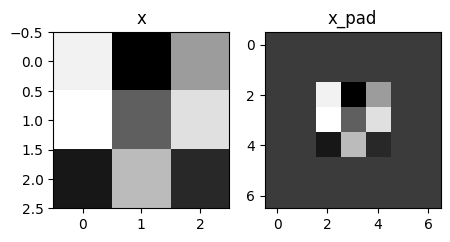

In [44]:
print("x.shape :",x.shape)
print("x_pad.shape :",x_pad.shape)
print("x[1,1] :", x[1,1])
print("x_pad[1,1 :",x_pad[1,1])

fig, axarr = plt.subplots(1,2)
axarr[0].set_title("x")
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title("x_pad")
axarr[1].imshow(x_pad[0,:,:,0])

#### Bir evrişim işleminin tanımlanması!

In [45]:
def conv_single_step(a_slice_prev,w,b):
    s = np.multiply(a_slice_prev, w)
    Z = np.sum(s)
    Z = float(b) + Z
    return Z

**Z=x.W+b Sonucunun hesaplanması**

In [46]:
np.random.seed(1)

a_slice_prev = np.random.randn(4, 4, 3)

W = np.random.randn(4, 4, 3)

b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)

print("Z :",Z)

Z : -6.999089450680221


/tmp/ipykernel_1813/826202923.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z = float(b) + Z


## İleri Yayılım Algoritması için fonksiyon tanımlayalım

In [47]:
def conv_forward(A_prev, W, b, hparamaters):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    (f, f, n_C_prev, n_C) = W.shape

    stride = hparamaters["stride"]
    pad = hparamaters["pad"]

    n_H = int(((n_H_prev - f + 2 * pad) / stride) + 1)
    n_W = int(((n_W_prev - f + 2 * pad) / stride) + 1)

    Z = np.zeros([m, n_H, n_W, n_C])

    A_prev_pad = zero_pad(A_prev, pad)

    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):

                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f

                    # Bu satırda a_slice_prev'in son boyutuna tüm kanallar dahil edilmelidir
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end]

                    # W[..., c] her bir kanal için filtreyi kullanıyoruz
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[..., c], b[..., c])

    assert (Z.shape == (m, n_H, n_W, n_C))

    cache = (A_prev, W, b, hparamaters)

    return Z, cache

In [48]:
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)

hparameters = {"pad": 2,
              "stride":2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

print("Z'nin ortalama :",np.mean(Z))
print("Z[3, 2, 1] :",Z[3, 2, 1])
print("cache_conv[0][1][2][3] :", cache_conv[0][1][2][3])

Z'nin ortalama : 0.048995203528855794
Z[3, 2, 1] : [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]
cache_conv[0][1][2][3] : [-0.20075807  0.18656139  0.41005165]


/tmp/ipykernel_1813/826202923.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z = float(b) + Z


In [49]:
def pool_forward(A_prev, hparameters, mode = "max"):
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    f = hparameters["f"]
    stride = hparameters["stride"]

    n_H = int(1 + (n_H_prev -f) / stride)
    n_W = int(1 + (n_H_prev -f) / stride)
    n_C = n_C_prev

    A = np.zeros((m, n_H, n_W, n_C))

    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):

                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f

                    a_prev_slice = A_prev[i, vert_start:vert_end,horiz_start:horiz_end,c]

                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    cache = (A_prev, hparameters)

    assert(A.shape ==(m, n_H, n_W, n_C))

    return A, cache

### Farklı ortaklama tipleri için sonuçları karşılaştıralım!

In [50]:
np.random.seed(1)

A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride":2, "f":3}

A, cache = pool_forward(A_prev,hparameters)

print("mod : max")
print("A :", A)

A, cache = pool_forward(A_prev,hparameters, mode="average")

print("mod : average")
print("A :", A)

mod : max
A : [[[[1.74481176 0.86540763 1.13376944]]]


 [[[1.13162939 1.51981682 2.18557541]]]]
mod : average
A : [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]


## Geriye Yayılım Algoritması için Fonksiyon Tanımlayalım

In [51]:
def conv_bacward(dZ, cache):
    
    (A_prev, W, b, hparameters) = cache
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    (f, f, n_C_prev, n_C) = W.shape

    stride = hparameters["stride"]
    pad = hparameters["pad"]

    (m, n_H, n_W, n_C) = dZ.shape

    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad =zero_pad(dA_prev, pad)

    for i in range (m):
        a_prev_pad = A_prev[i]
        da_prev_pad = dA_prev_pad[i]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    
                    vert_start = h 
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f

                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    da_prev_pad[vert_start:vert_end, 
                                horiz_start:horiz_end, :] += W[:, :, :, c] * dZ[i, h, w, c]

                    dW[:, :, :, c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad,:]

    assert (dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))

    return dA_prev, dW, db

In [52]:
np.random.seed(1)
dA, dW, db = conv_bacward(Z, cache_conv)

print("dA ortalama :", np.mean(dA))
print("dW ortalama :", np.mean(dW))
print("db ortalama :", np.mean(db))

dA ortalama : 0.6347704472654743
dW ortalama : 2.4767500956259423
db ortalama : 7.839232564616838


In [53]:
def create_mask_from_window(x):
    mask = x == np.max(x)
    return mask

In [54]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)

print("x :", x)
print("Mask : ", mask)

x : [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
Mask :  [[ True False False]
 [False False False]]


In [55]:
def distribute_value(dZ, shape):
    (n_H, n_W) = shape

    average = dZ / (n_H * n_W)

    a= np.ones(shape) * average

    return a

In [56]:
a = distribute_value(2, (2,2))

print("dağıtılmış değer",a)

dağıtılmış değer [[0.5 0.5]
 [0.5 0.5]]


In [57]:
def pool_backward(dA, cache, mode="max"):

    #(A_prev, hparameters) = cache
    (A_prev, hparameters) = cache


   #stride = hparameters['stride']
    stride = hparameters["stride"]
   #f = hparameters['f']
    f = hparameters["f"]

   #m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape 
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
   #m, n_H, n_W, n_C = dA.shape
    m, n_H, n_W, n_C = dA.shape

    dA_prev = np.zeros(A_prev.shape)

    for i in range(m):

        
        a_prev = A_prev[i]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    
                    vert_start = h 
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f

                    if mode == "max":

                        
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                        
                    elif mode == "average":
                        
                        da = dA[i, h, w, c]
                        shape = (f, f)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end,c] += distribute_value(da,shape)


    assert(dA_prev.shape == A_prev.shape)

    return dA_prev

### Geriye yayılım ile güncellenen ağırlıklar ve diğer parametreler

In [58]:
np.random.seed(1)

A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride":2,"f":2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2 ,2)

dA_prev = pool_backward(dA, cache, mode="max")

print("mod : max")
print("dA'nın ortalaması :",np.mean(dA))
print("dA_prev[1,1] : ",dA_prev[1,1])
print()

dA_prev = pool_backward(dA, cache, mode="average")

print("mod : average")
print("dA'nın ortalaması :",np.mean(dA))
print("dA_prev[1,1] : ",dA_prev[1,1])
print()

mod : max
dA'nın ortalaması : 0.14571390272918056
dA_prev[1,1] :  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mod : average
dA'nın ortalaması : 0.14571390272918056
dA_prev[1,1] :  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]

